<a href="https://colab.research.google.com/github/Arjun3574/-Feature-Engineering-/blob/main/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image Dataset




In [5]:
# Install kagglehub (if not already installed in the Colab env)
!pip install -q kagglehub

import kagglehub
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Download latest version
print("Downloading dataset...")
path = kagglehub.dataset_download("anthonytherrien/dog-vs-cat")
print("Download complete. Path to dataset files:", path)


data_dir = os.path.join(path, 'animals')

# Check if this new path is correct before proceeding
if not os.path.exists(data_dir):
    print(f"--- ERROR ---")
    print(f"Tried to find {data_dir}, but it doesn't exist.")
    print(f"Contents of {path}: {os.listdir(path)}")
else:
    print(f"\nSuccessfully found data directory at: {data_dir}")
    print(f"Contents of data directory: {os.listdir(data_dir)}")

# Define image and batch parameters here
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

Download complete. Path to dataset files: /root/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3

Successfully found data directory at: /root/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3/animals
Contents of data directory: ['dog', 'cat']


Loading training data from: /root/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3/animals
Found 1000 files belonging to 2 classes.
Using 800 files for training.
Loading validation data...
Found 1000 files belonging to 2 classes.
Using 200 files for validation.

Class names found: ['cat', 'dog']
Showing a batch of training images...


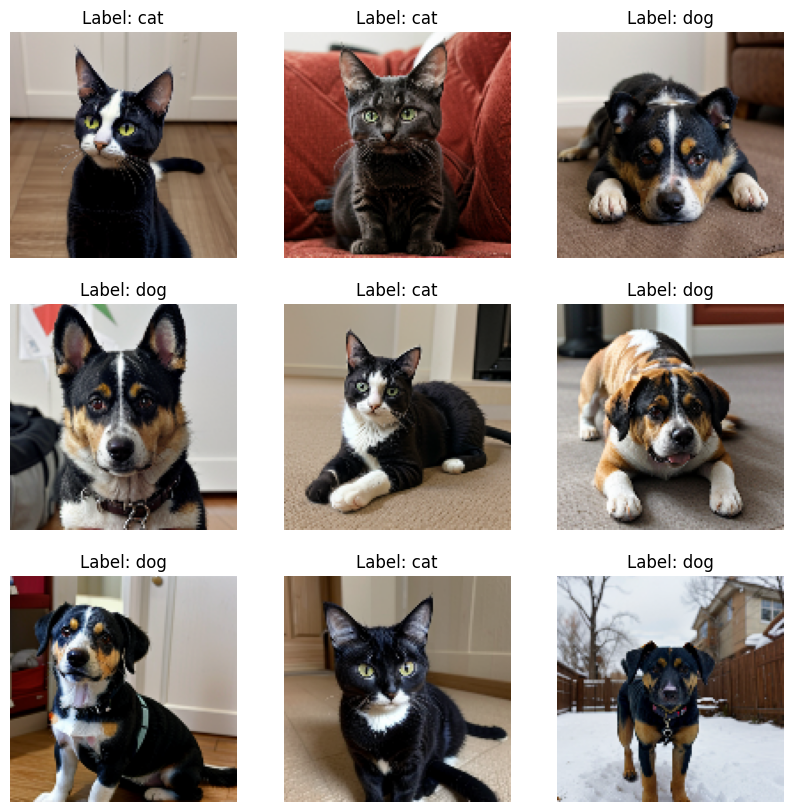

In [6]:
# The 'data_dir' variable is from Cell 1
print(f"Loading training data from: {data_dir}")

# Load the training dataset from the new 'data_dir'
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='binary',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print("Loading validation data...")
# Load the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='binary',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

#  Explore the data
class_names = train_dataset.class_names
print(f"\nClass names found: {class_names}")

# Let's look at the first batch of images and labels
print("Showing a batch of training images...")
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Display the image
        plt.imshow(images[i].numpy().astype("uint8"))

        # Show the label
        label_name = class_names[int(labels[i])]
        plt.title(f"Label: {label_name}")

        plt.axis("off")
plt.show()

In [7]:
# Get the specific preprocessing function for MobileNetV2
# This scales pixels from [0, 255] to [-1, 1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Use .map() to apply this function efficiently to both datasets
# This is much faster than looping
train_ds_scaled = train_dataset.map(lambda x, y: (preprocess_input(x), y))
val_ds_scaled = validation_dataset.map(lambda x, y: (preprocess_input(x), y))

print("Feature scaling complete.")

Feature scaling complete.


In [8]:
# 1. Load the pre-trained base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3), # 128x128x3
    include_top=False,
    weights='imagenet'
)

# 2. Freeze the base model
base_model.trainable = False

print("Pre-trained MobileNetV2 base model loaded and frozen.")
base_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Pre-trained MobileNetV2 base model loaded and frozen.


Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Build the model
inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))

# The base_model (our feature extractor)
x = base_model(inputs, training=False)

# This layer fulfills "Feature Selection" by reducing features
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Our final classifier layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the final model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully.")
model.summary()

#  Train the model
print("\nStarting model training...")
history = model.fit(
    train_ds_scaled,
    epochs=3, # 3 epochs is fast and shows the concept
    validation_data=val_ds_scaled
)

print("Training complete.")

#  Evaluate the model
loss, accuracy = model.evaluate(val_ds_scaled)
print(f"\nValidation Accuracy: {accuracy*100:.2f}%")

Model compiled successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Starting model training...
Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7935 - loss: 0.4213 - val_accuracy: 1.0000 - val_loss: 0.0509
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 795ms/step - accuracy: 0.9969 - loss: 0.0367 - val_accuracy: 1.0000 - val_loss: 0.0219
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 815ms/step - accuracy: 0.9999 - loss: 0.0199 - val_accuracy: 1.0000 - val_loss: 0.0153
Training complete.
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 502ms/step - accuracy: 1.0000 - loss: 0.0162

Validation Accuracy: 100.00%


Text Dataset


In [10]:
# Install kagglehub (if not already installed in the Colab env)
!pip install -q kagglehub

# Import libraries
import kagglehub
import pandas as pd
import numpy as np
import os
import re # For text cleaning
import nltk # Natural Language Toolkit
from nltk.corpus import stopwords

# Import scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Download the dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Download complete. Path to dataset files:", path)

# Create the full path to the CSV file
imdb_csv_path = os.path.join(path, 'IMDB Dataset.csv')
print(f"CSV file found at: {imdb_csv_path}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


100%|██████████| 25.7M/25.7M [00:00<00:00, 108MB/s]

Extracting files...


Download complete. Path to dataset files: /root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1
CSV file found at: /root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1/IMDB Dataset.csv


In [11]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv(imdb_csv_path)

# --- Explore the dataset ---

# 1. Show the first 5 rows
print("--- Head ---")
print(df.head())

# 2. Check data types and non-null counts
print("\n--- Info ---")
df.info()

# 3. Check for missing values (Task 2)
print("\n--- Missing Values ---")
print(df.isnull().sum())

# 4. Check the balance of our target variable 'sentiment'
print("\n--- Target Distribution (Sentiment) ---")
print(df['sentiment'].value_counts())

--- Head ---
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB

--- Missing Values ---
review       0
sentiment    0
dtype: int64

--- Target Distribution (Sentiment) ---
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [12]:
# 1. --- Clean the text data (X) ---
def clean_text(text):
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text) # Remove punctuation and numbers
    text = text.lower() # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words]) # Remove stop words
    return text

print("Cleaning text data...")
# Apply the cleaning function to the 'review' column
df['cleaned_review'] = df['review'].apply(clean_text)

# 2. --- Encode Categorical Variables (y) ---
# The target 'sentiment' is categorical ('positive', 'negative')
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['sentiment'])

print("Encoding complete.")
print(f"Classes found: {le.classes_}")
print("0 maps to:", le.transform(['negative'])[0])
print("1 maps to:", le.transform(['positive'])[0])

# --- Show the result ---
print("\n--- DataFrame after Cleaning and Encoding ---")
print(df[['cleaned_review', 'sentiment', 'sentiment_encoded']].head())

Cleaning text data...
Encoding complete.
Classes found: ['negative' 'positive']
0 maps to: 0
1 maps to: 1

--- DataFrame after Cleaning and Encoding ---
                                      cleaned_review sentiment  \
0  one reviewers mentioned watching oz episode ho...  positive   
1  wonderful little production filming technique ...  positive   
2  thought wonderful way spend time hot summer we...  positive   
3  basically family little boy jake thinks zombie...  negative   
4  petter mattei love time money visually stunnin...  positive   

   sentiment_encoded  
0                  1  
1                  1  
2                  1  
3                  0  
4                  1  


In [13]:
# 1. Define our features (X) and target (y)
X = df['cleaned_review']
y = df['sentiment_encoded']

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# 3. Apply Feature Extraction (TF-IDF)
# We will extract the top 5000 most important words/terms
print("\nExtracting features using TF-IDF...")
vectorizer = TfidfVectorizer(max_features=5000) # max_features acts as a form of feature selection

# Fit on training data and transform both train and test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF extraction complete.")
print(f"Shape of TF-IDF matrix (train): {X_train_tfidf.shape}")
print(f"Shape of TF-IDF matrix (test): {X_test_tfidf.shape}")

Training set size: 40000
Test set size: 10000

Extracting features using TF-IDF...
TF-IDF extraction complete.
Shape of TF-IDF matrix (train): (40000, 5000)
Shape of TF-IDF matrix (test): (10000, 5000)


In [14]:
# We will select the k=2000 best features from our 5000 TF-IDF features
K_BEST = 2000

print(f"Selecting {K_BEST} best features using Chi-Squared test...")
selector = SelectKBest(chi2, k=K_BEST)

# Fit on the training data
X_train_selected = selector.fit_transform(X_train_tfidf, y_train)
X_test_selected = selector.transform(X_test_tfidf)

print("Feature selection complete.")
print(f"Shape after selection (train): {X_train_selected.shape}")
print(f"Shape after selection (test): {X_test_selected.shape}")

Selecting 2000 best features using Chi-Squared test...
Feature selection complete.
Shape after selection (train): (40000, 2000)
Shape after selection (test): (10000, 2000)
